# Testing InceptionV3 network (variation 1)

In this notebook I use the data explored and processed in notebooks 1-3 to see how well the pretrained InceptionV3 model works as a classifier.

In [1]:
import os
import time
import pickle

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import metrics

#TODO implement this function
from cars_utils import time_save_model, plot_metrics

Using TensorFlow backend.


### BASIC  IMAGE, AND BATCH SETUP

In [2]:
# Image dimensions:
IMG_WIDTH, IMG_HEIGHT = 299, 299

WORKING_DIR = os.getcwd()
BASE = os.path.join(WORKING_DIR, 'data', 'cars_dataset', 'keras')

SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'InceptionV3')

### Settings for full training
# TRAIN_DATA_DIR = os.path.join(BASE, 'train')
# VALIDATION_DATA_DIR = os.path.join(BASE, 'validation')
# NB_CLASSES = 196
# NB_TRAIN_SAMPLES = 11329
# NB_VALIDATION_SAMPLES = 2428
# BATCH_SIZE = 32

### Settings for fast checking
# SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'fast_test')
# TRAIN_DATA_DIR = os.path.join(BASE, 'fast', 'train')
# VALIDATION_DATA_DIR = os.path.join(BASE, 'fast', 'validation')
# NB_CLASSES = 196
# NB_TRAIN_SAMPLES = NB_CLASSES*2
# NB_VALIDATION_SAMPLES = NB_CLASSES
# BATCH_SIZE = 4

### Settings for faster checking
SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'fast_v2_test')
TRAIN_DATA_DIR = os.path.join(BASE, 'fast_v2', 'train')
VALIDATION_DATA_DIR = os.path.join(BASE, 'fast_v2', 'validation')
NB_CLASSES = 6
NB_TRAIN_SAMPLES = NB_CLASSES*2
NB_VALIDATION_SAMPLES = NB_CLASSES
BATCH_SIZE = 4

if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [3]:
from keras.applications import InceptionV3

conv_total = InceptionV3(
    weights='imagenet',
    include_top=True,
    input_shape=INPUT_SHAPE
)

96116736/96112376 [==============================] - 14s 0us/step


In [4]:
conv_total.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [24]:
second_to_last = conv_total.get_layer(index=-2)
second_to_last_config = second_to_last.get_config()
second_to_last_config

{'data_format': 'channels_last', 'name': 'avg_pool', 'trainable': True}

In [25]:
pred_layer = conv_total.get_layer(index=-1)
pred_layer_config = pred_layer.get_config()
pred_layer_config

{'activation': 'softmax',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'predictions',
 'trainable': True,
 'units': 1000,
 'use_bias': True}

In [6]:
conv_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=INPUT_SHAPE
)

87916544/87910968 [==============================] - 12s 0us/step


In [7]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [28]:
from keras import regularizers

pred_layer_config = {
    'activation': 'softmax',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
                           'config': {
                               'distribution': 'uniform',
                               'mode': 'fan_avg',
                               'scale': 1.0,
                               'seed': 8}
                          },
    'kernel_regularizer': None,
    'name': 'predictions',
    'trainable': True,
    'units': NB_CLASSES,
    'use_bias': True}

model = Sequential()
model.add(conv_base)
model.add(Dense(**pred_layer_config))

conv_base.trainable = True
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 190
This is the number of trainable weights after freezing the conv base: 2


In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
predictions (Dense)          (None, 6)                 12294     
Total params: 21,815,078
Trainable params: 12,294
Non-trainable params: 21,802,784
_________________________________________________________________


In [10]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 12 images belonging to 6 classes.
Found 6 images belonging to 6 classes.


Define custom metrics to measure

In [13]:
def top_3_acc(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

In [30]:
from keras import optimizers

optimizer = optimizers.RMSprop(lr=0.0001, rho=0.9)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=[metrics.categorical_accuracy, top_3_acc])

In [31]:
EPOCHS = 1
start_time = time.time()
summary = model.fit_generator(
    train_generator,
    steps_per_epoch=NB_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=NB_VALIDATION_SAMPLES // BATCH_SIZE)
end_time = time.time()

Epoch 1/1
3/3 [==============================] - 29s 10s/step - loss: 1.8546 - categorical_accuracy: 0.1667 - top_3_acc: 0.5000 - val_loss: 1.8245 - val_categorical_accuracy: 0.0000e+00 - val_top_3_acc: 0.7500


In [32]:
time_save_model(model,
                summary.history,
                start_time, end_time,
                '1_InceptionV3_0_30',
                SAVE_DIR)

traing took: 1.0 minutes


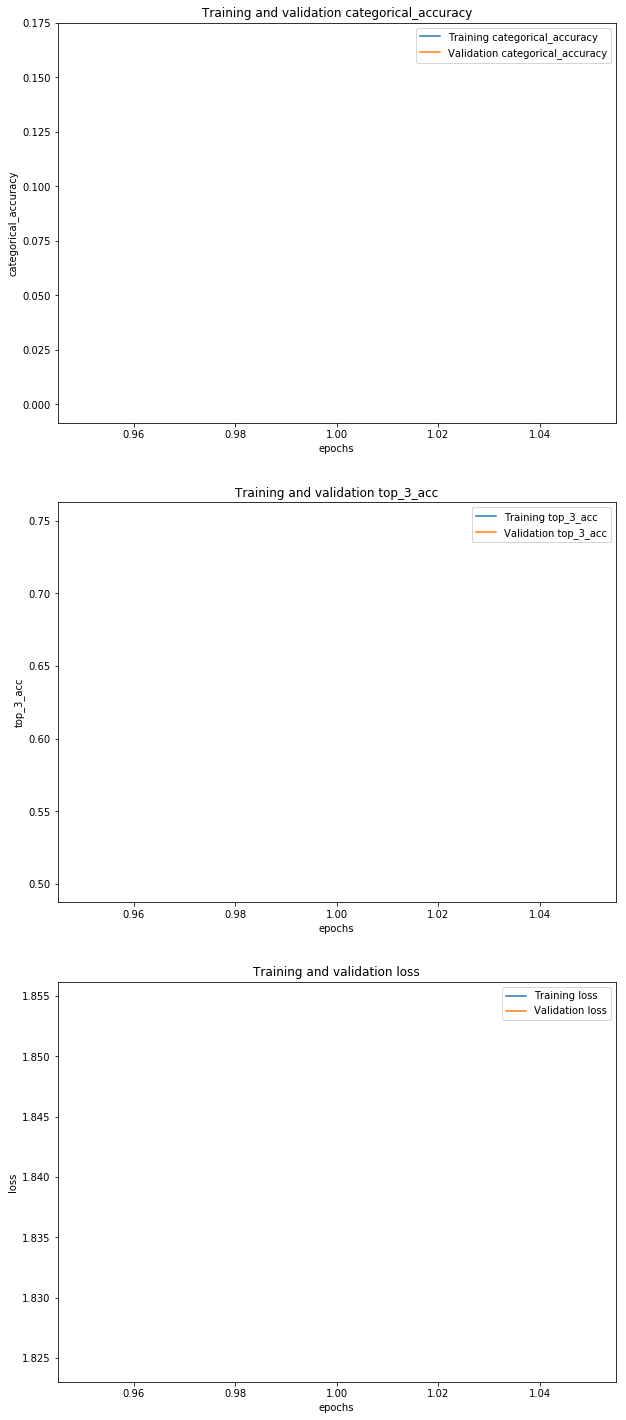

In [33]:
key_list = ['categorical_accuracy',
            'top_3_acc',
            'loss']
show = plot_metrics(summary.history, key_list)